In [247]:
import numpy
import random
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [248]:
from datetime import datetime, timedelta
now = datetime.now().replace(second=0, microsecond=0) - timedelta(days=365*5)

In [249]:
ROOM_TEMP = 24.0

In [250]:
DESIGN_MIN_VOLTAGE = 2700  # mV
DESIGN_MAX_VOLTAGE = 4200  # mV

In [251]:
### FOR NORMAL DATA:
NORMAL_DISCHARGE_CURRENT = -3000  # mA
NORMAL_CHARGE_CURRENT = 5000  # mA

NORMAL_VOLTAGE_DROP_RATE = 0.13
NORMAL_VOLTAGE_GROW_RATE = 0.2

In [252]:
### FOR LOW POWER DATA:
LOW_DISCHARGE_CURRENT = -200  # mA

LOW_POWER_VOLTAGE_DROP_RATE = 0.02

In [253]:
### FOR SHORT DURATION DATA:
EARLY_MIN_VOLTAGE = 3800  # mV

In [254]:
N_CYCLES = 900
BLOCK_SIZE = 9

N_PLOTS = BLOCK_SIZE * 3

In [255]:
def generate_discharge_charge_data(initial_temp, initial_current, initial_voltage, final_discharge_voltage, final_charge_voltage, voltage_drop_rate, voltage_grow_rate, cycle, state_of_health, normal, directory, discharge_offline_gap=None, charge_offline_gap=None):
    global now

    path = Path(directory)
    path.mkdir(parents=True, exist_ok=True)
    with open(f"{str(path)}/data_{cycle}.csv","w") as f:
        f.write(f"TimeStamp,Temperature,Voltage,Current,Relative State of Charge,State of Health,{normal}\n")

        # initialisation
        temp = initial_temp
        voltage = initial_voltage
        current = initial_current
        const_power = voltage * current

        # starting state
        f.write(f"{now},"
                f"{temp:.1f},"
                f"{int(voltage)},"
                f"{0},"
                f"{int((voltage-DESIGN_MIN_VOLTAGE)/(DESIGN_MAX_VOLTAGE-DESIGN_MIN_VOLTAGE)*100)},"
		f"{int(state_of_health)}\n")
        
        now += timedelta(minutes=1)


        # discharge first
        i = 0
        offline = (random.uniform(0,1) < BLOCK_SIZE / N_CYCLES) # chance of unit going offline is 1 block per generation
        while voltage > final_discharge_voltage:
            frac = 1 - (voltage - final_discharge_voltage) / (initial_voltage - final_discharge_voltage)
            dv = (initial_voltage - final_discharge_voltage) * voltage_drop_rate * max(frac, 0.001)
            voltage -= random.gauss(dv, 0.2 * dv)
            if voltage < final_discharge_voltage:
                voltage = final_discharge_voltage
            current = const_power / voltage
            temp += random.uniform(0.01,0.07)

            if (discharge_offline_gap is not None) and (i>discharge_offline_gap[0] and i<discharge_offline_gap[1]) and offline == True:
                # dont write
                pass
            else:
                f.write(f"{now},"
                        f"{temp:.1f},"
                        f"{int(voltage)},"
                        f"{int(current+random.gauss(0,1))},"
                        f"{int((voltage-DESIGN_MIN_VOLTAGE)/(DESIGN_MAX_VOLTAGE-DESIGN_MIN_VOLTAGE)*100)},"
                        f"{int(state_of_health)}\n")

            now += timedelta(minutes=1)
            i += 1


        # rest period
        for _ in range(5):
            voltage += random.gauss(1.5, 1)
            temp -= random.uniform(0.03,0.16)

            f.write(f"{now},"
                    f"{temp:.1f},"
                    f"{int(voltage)},"
                    f"{0},"
                    f"{int((voltage-DESIGN_MIN_VOLTAGE)/(DESIGN_MAX_VOLTAGE-DESIGN_MIN_VOLTAGE)*100)},"
		    f"{int(state_of_health)}\n")

            now += timedelta(minutes=1)


        # then charge to full again ready for next cycle
        i = 0
        offline = (random.uniform(0,1) < BLOCK_SIZE / N_CYCLES) # chance of unit going offline is 1 block per generation
        while voltage < final_charge_voltage:
            dv = (final_charge_voltage - voltage) * voltage_grow_rate
            voltage += random.gauss(dv, 0.2 * dv)
            if voltage > 0.999 * final_charge_voltage:
                voltage = final_charge_voltage
            current = random.gauss(NORMAL_CHARGE_CURRENT, 0.01 * NORMAL_CHARGE_CURRENT)
            temp += random.uniform(0.01,0.07)

            if (charge_offline_gap is not None) and (i>charge_offline_gap[0] and i<charge_offline_gap[1]) and offline == True:
                # dont write
                pass
            else:
                f.write(f"{now},"
                        f"{temp:.1f},"
                        f"{int(voltage)},"
                        f"{int(current+random.gauss(0,1))},"
                        f"{int((voltage-DESIGN_MIN_VOLTAGE)/(DESIGN_MAX_VOLTAGE-DESIGN_MIN_VOLTAGE)*100)},"
                        f"{int(state_of_health)}\n")

            now += timedelta(minutes=1)
            i += 1


        # rest period
        for i in range(5):
            voltage = random.gauss(final_charge_voltage, 0.0001 * final_charge_voltage)
            temp -= random.uniform(0.03,0.16)

            f.write(f"{now},"
                    f"{temp:.1f},"
                    f"{int(voltage)},"
                    f"{0},"
                    f"{int((voltage-DESIGN_MIN_VOLTAGE)/(DESIGN_MAX_VOLTAGE-DESIGN_MIN_VOLTAGE)*100)},"
		    f"{int(state_of_health)}\n")

            now += timedelta(minutes=1)

In [256]:
normal_soh_reduction = 0.005
fast_soh_reduction = 0.010
very_fast_soh_reduction = 0.015

In [257]:
# normal
state_of_health = 100.0
normal = True
for i in range(N_CYCLES):
    generate_discharge_charge_data(ROOM_TEMP, NORMAL_DISCHARGE_CURRENT, DESIGN_MAX_VOLTAGE, DESIGN_MIN_VOLTAGE, DESIGN_MAX_VOLTAGE, NORMAL_VOLTAGE_DROP_RATE, NORMAL_VOLTAGE_GROW_RATE, i+1, state_of_health, True, "data/normal", discharge_offline_gap=(40,55), charge_offline_gap=(10,20))
    state_of_health -= normal_soh_reduction

In [258]:
# low power
state_of_health = 100.0
normal = True
for i in range(N_CYCLES):
    if i%BLOCK_SIZE == 0:
        normal = random.uniform(0,1) < 0.5
    if normal:
        generate_discharge_charge_data(ROOM_TEMP, NORMAL_DISCHARGE_CURRENT, DESIGN_MAX_VOLTAGE, DESIGN_MIN_VOLTAGE, DESIGN_MAX_VOLTAGE, NORMAL_VOLTAGE_DROP_RATE, NORMAL_VOLTAGE_GROW_RATE, i+1, state_of_health, True, "data/low_power", discharge_offline_gap=(40,55), charge_offline_gap=(10,20))
        state_of_health -= normal_soh_reduction
    else:
        generate_discharge_charge_data(ROOM_TEMP, LOW_DISCHARGE_CURRENT, DESIGN_MAX_VOLTAGE, DESIGN_MIN_VOLTAGE, DESIGN_MAX_VOLTAGE, LOW_POWER_VOLTAGE_DROP_RATE, NORMAL_VOLTAGE_GROW_RATE, i+1, state_of_health, False, "data/low_power", discharge_offline_gap=(200,300), charge_offline_gap=(10,20))
        state_of_health -= fast_soh_reduction

In [259]:
# short duration
state_of_health = 100.0
normal = True
for i in range(N_CYCLES):
    if i%BLOCK_SIZE == 0:
        normal = random.uniform(0,1) < 0.5
    if normal:
        generate_discharge_charge_data(ROOM_TEMP, NORMAL_DISCHARGE_CURRENT, DESIGN_MAX_VOLTAGE, DESIGN_MIN_VOLTAGE, DESIGN_MAX_VOLTAGE, NORMAL_VOLTAGE_DROP_RATE, NORMAL_VOLTAGE_GROW_RATE, i+1, state_of_health, True, "data/short_duration", discharge_offline_gap=(40,55), charge_offline_gap=(10,20))
        state_of_health -= normal_soh_reduction
    else:
        generate_discharge_charge_data(ROOM_TEMP, NORMAL_DISCHARGE_CURRENT, DESIGN_MAX_VOLTAGE, EARLY_MIN_VOLTAGE, DESIGN_MAX_VOLTAGE, NORMAL_VOLTAGE_DROP_RATE, NORMAL_VOLTAGE_GROW_RATE, i+1, state_of_health, False, "data/short_duration", discharge_offline_gap=(40,55), charge_offline_gap=(10,20))
        state_of_health -= very_fast_soh_reduction

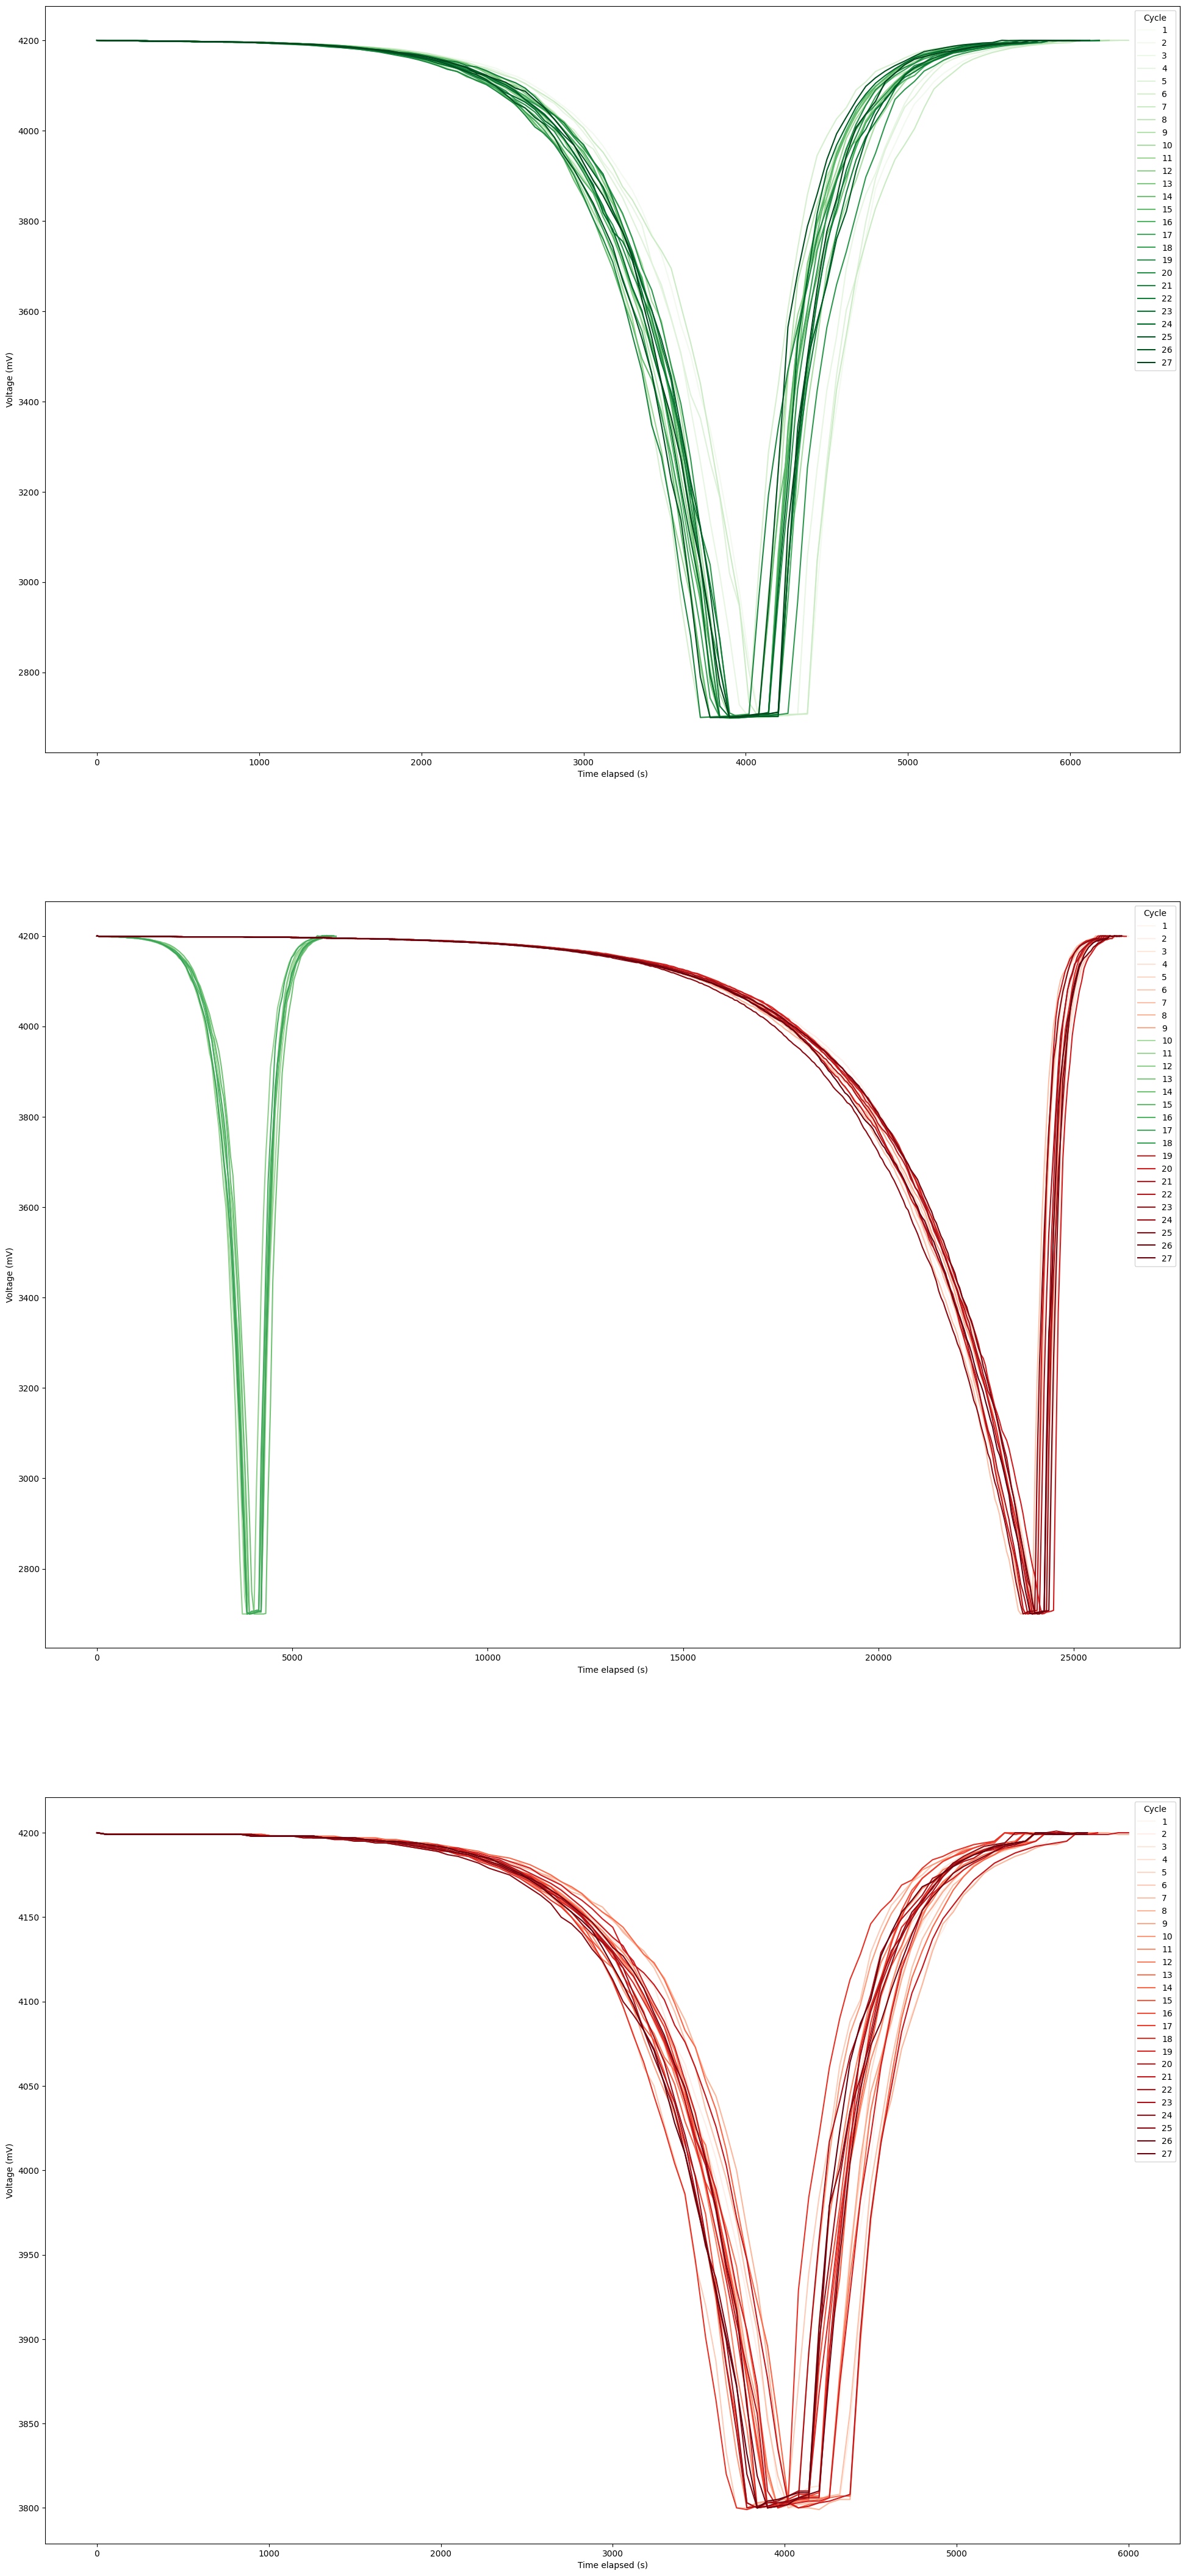

In [ ]:
fig, axs = plt.subplots(3,1,figsize=(24,54))

green_cmap = cm.Greens
red_cmap = cm.Reds
norm = mcolors.Normalize(vmin=0, vmax=N_PLOTS-1)

for path, j in zip(["normal", "low_power", "short_duration"], range(3)):
    normal = True
    for i in range(N_PLOTS):
        green = green_cmap(norm(i))
        red = red_cmap(norm(i))

        timestamps, voltages = [], []
        with open(f"data/{path}/data_{i+1}.csv", "r") as f:
            for l in f:
                if l.startswith("TimeStamp"):
                    _, _, _, _, _, _, normal = l.strip().split(",")
                    normal = True if normal=="True" else False
                    continue

                timestamp, _, voltage, *_ = l.strip().split(",")
                timestamps.append(datetime.fromisoformat(timestamp))
                voltages.append(float(voltage))

        times = numpy.array([(t - timestamps[0]).total_seconds() for t in timestamps])
        voltages = numpy.array(voltages)

        # break line where gap > 60s
        gaps = numpy.diff(times) > 60
        break_idx = numpy.where(gaps)[0] + 1
        times[break_idx] = numpy.nan
        voltages[break_idx] = numpy.nan

        axs[j].plot(times, voltages, color=green if normal==True else red, label=i+1)
        axs[j].set_xlabel("Time elapsed (s)")
        axs[j].set_ylabel("Voltage (mV)")
        axs[j].legend(title="Cycle")